In [2957]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import yfinance as yf




In [2958]:
#ENTER YOUR USERNAME 

user = 'omarlodhi'

# df_total

# Define the folder containing the CSV files
folder_path = f'/Users/{user}/Downloads/UVAmacro-main/post_2/data'
figure_path = f'/Users/{user}/Downloads/UVAmacro-main/post_2/figures'

df_1yr_swap_rate = pd.read_csv(f'{folder_path}/1yr_swap_rate.csv')
df_2yr_swap_rate = pd.read_csv(f'{folder_path}/2yr_swap_rate.csv')  # Fixed path
df_size = pd.read_csv(f'{folder_path}/size.csv')  # Fixed path
df_10yr_yield = pd.read_csv(f'{folder_path}/10yr_yield.csv')  # Fixed path
df_BE = pd.read_csv(f'{folder_path}/5y5y.csv')  # Fixed path
df_term_model = pd.read_csv(f'{folder_path}/FRBSF_Term_Model_Data.csv')
df_2yr_yield = pd.read_csv(f'{folder_path}/2yr_yield.csv')
df_frb_observed = pd.read_csv(f'{folder_path}/frb_observed.csv')
df_frb_observedpolicy = pd.read_csv(f'{folder_path}/frb_observedpolicy.csv')
df_frb_observedtp = pd.read_csv(f'{folder_path}/frb_observedtp.csv')


df_term_model.rename(columns={'10yr_yield': '10yr_yield_fitted'}, inplace=True)
df_term_model['Date'] = pd.to_datetime(df_term_model['Date'])
df_term_model['10yr_yield_fitted'] = df_term_model['10yr_yield_fitted']*100
df_term_model['policy'] = df_term_model['policy']*100
df_term_model['10y_tp'] = df_term_model['10y_tp']*100




# 1-year swap rate processing
df_1yr_swap_rate = df_1yr_swap_rate[['Date', 'Price']]
df_1yr_swap_rate.rename(columns={'Price': '1yr_swap_rate'}, inplace=True)
df_1yr_swap_rate['Date'] = pd.to_datetime(df_1yr_swap_rate['Date'])

# 2-year swap rate processing
df_2yr_swap_rate = df_2yr_swap_rate[['Date', 'Price']]
df_2yr_swap_rate.rename(columns={'Price': '2yr_swap_rate'}, inplace=True)
df_2yr_swap_rate['Date'] = pd.to_datetime(df_2yr_swap_rate['Date'])

# Size processing
df_size['Date'] = pd.to_datetime(df_size['Date'])
df_size['Prop'] = (df_size['Holdings'] / 1000000) / 28

# 10-year yield processing
df_10yr_yield = df_10yr_yield[['Date', 'Price']]
df_10yr_yield.rename(columns={'Price': '10yr_yield'}, inplace=True)
df_10yr_yield['Date'] = pd.to_datetime(df_10yr_yield['Date'])

df_2yr_yield = df_2yr_yield[['Date', 'Price']]
df_2yr_yield.rename(columns={'Price': '2yr_yield'}, inplace=True)
df_2yr_yield['Date'] = pd.to_datetime(df_10yr_yield['Date'])

# BE processing
df_BE['Date'] = pd.to_datetime(df_BE['Date'])

df_frb_observed['Date'] = pd.to_datetime(df_frb_observed['Date'])
df_frb_observedpolicy['Date'] = pd.to_datetime(df_frb_observedpolicy['Date'])
df_frb_observedtp['Date'] = pd.to_datetime(df_frb_observedtp['Date'])



#merge all 

df_total = pd.merge(df_1yr_swap_rate, df_2yr_swap_rate, on='Date', how='inner')
df_total = pd.merge(df_total, df_size, on='Date', how='inner')
df_total = pd.merge(df_total, df_BE, on='Date', how='inner')
df_total = pd.merge(df_total, df_2yr_yield, on='Date', how='inner')
df_total = pd.merge(df_total, df_frb_observed, on='Date', how='inner')
df_total = pd.merge(df_total, df_frb_observedpolicy, on='Date', how='inner')
df_total = pd.merge(df_total, df_frb_observedtp, on='Date', how='inner')



df_total['10y_tp'] = df_total['10y_tp']*100
df_total['policy'] = df_total['policy']*100
df_total['10yr_yield'] = df_total['10yr_yield']*100

df_total = df_total.sort_values(by='Date')

def find_closest_prop(date, df_size):
    # Find the closest date in df_size
    closest_date_idx = (df_size['Date'] - date).abs().idxmin()  # Find index of the closest date
    closest_prop = df_size.loc[closest_date_idx, 'Prop']  # Get the Prop value for the closest date
    return closest_prop

df_total['Prop'] = df_total['Date'].apply(lambda x: find_closest_prop(x, df_size))

df_total['1y1y'] = ((1 + df_total['2yr_swap_rate'])**2 / (1 + df_total['1yr_swap_rate'])) - 1



# df_trial

folder_path = f'/Users/{user}/Downloads/UVAmacro-main/post_2/data'

df_spy = pd.read_csv(f'{folder_path}/S&P 500 Historical Data.csv')
df_term_model = pd.read_csv(f'{folder_path}/FRBSF_Term_Model_Data.csv')
df_5y_BE = pd.read_csv(f'{folder_path}/T5YIE.csv')

df_spy.rename(columns={'Price': 'spy'}, inplace=True)
df_spy['spy'] = df_spy['spy'].replace({',': ''}, regex=True).astype(float)
df_spy['Date'] = pd.to_datetime(df_spy['Date'])

df_5y_BE['Date'] = pd.to_datetime(df_5y_BE['Date'])


#merge all 

df_trial = pd.merge(df_frb_observed, df_spy, on='Date', how='inner')
df_trial = pd.merge(df_trial, df_5y_BE, on='Date', how='inner')
df_trial = pd.merge(df_trial, df_frb_observedpolicy, on='Date', how='inner')
df_trial = pd.merge(df_trial, df_frb_observedtp, on='Date', how='inner')

df_trial['10yr_yield'] = df_trial['10yr_yield'] * 10000
df_trial['policy'] = df_trial['policy'] * 10000
df_trial['10y_tp'] = df_trial['10y_tp'] * 10000
df_trial['5yBE'] = df_trial['5yBE'] * 100

print(df_total.columns)


Index(['Date', '1yr_swap_rate', '2yr_swap_rate', 'Holdings', 'Prop', 'BE',
       '2yr_yield', '10yr_yield', 'policy', '10y_tp', '1y1y'],
      dtype='object')


                            OLS Regression Results                            
Dep. Variable:             10yr_yield   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     2428.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):          1.23e-186
Time:                        18:33:04   Log-Likelihood:                -10.267
No. Observations:                 258   AIC:                             28.53
Df Residuals:                     254   BIC:                             42.75
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3101      0.152     -2.041      0.0

/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_70441/1091368870.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f'Date\n\nmodel standard error (bp): {results.bse[0]*100:.2f} \n r^2: {results.rsquared:.2f


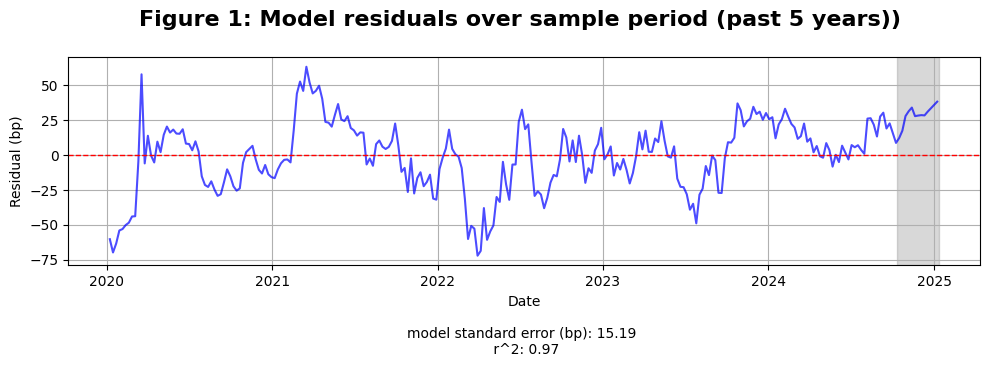

Model Standard Error (Root MSE): 0.1519
Average residual from 2024-10-06 to 2025-01-15: 15.2566 bps
Current residual (at the final date): 38.2115 bps


/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_70441/1091368870.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Model Standard Error (Root MSE): {results.bse[0]:.4f}")


In [2959]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

df_total.dropna(inplace=True)  # Drop rows with missing values

# Assuming df_total is already defined with your data and includes the 'Date' column.
df_total = df_total[df_total['Date'] >= '2020-01-01']
# Main regression
X = df_total[['1y1y', 'BE', 'Prop']]  # Independent variables
y = df_total['10yr_yield']  # Dependent variable

# Add a constant to the independent variables matrix (for the intercept in the regression)
X = sm.add_constant(X)


# Perform the OLS regression
model = sm.OLS(y, X)  # Ordinary Least Squares regression
results = model.fit()

# Display the regression summary (model parameters and standard error)
print(results.summary())

# Calculate the residuals
y_pred = results.predict(X)  # Predicted values
residuals = y - y_pred  # Residuals
residuals = residuals*100  # Convert to basis points (bps)
df_total['residuals'] = residuals

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(df_total['Date'], residuals, color='blue', alpha=0.7)
plt.xlabel(f'Date\n\nmodel standard error (bp): {results.bse[0]*100:.2f} \n r^2: {results.rsquared:.2f
}')
plt.ylabel('Residual (bp)')
plt.title('Figure 1: Model residuals over sample period (past 5 years)) \n', fontsize=16, fontweight='bold')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a red dashed line at 0
plt.axvspan('2024-10-11', '2025-01-11', color='grey', alpha=0.3)  # Highlight the spanned period
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{figure_path}/figure_1.jpg', format='jpeg', bbox_inches='tight')
plt.show()


# 1. Standard error of the model
print(f"Model Standard Error (Root MSE): {results.bse[0]:.4f}")

# 2. Average residual in the spanned date period
spanned_period = (df_total['Date'] >= '2023-10-06') & (df_total['Date'] <= '2024-07-28')
average_residual = residuals[spanned_period].mean()
print(f"Average residual from 2024-10-06 to 2025-01-15: {average_residual:.4f} bps")

# 3. Current residual (at the final date)
current_residual = residuals.iloc[-1]  # Residual at the final date
print(f"Current residual (at the final date): {current_residual:.4f} bps")


 

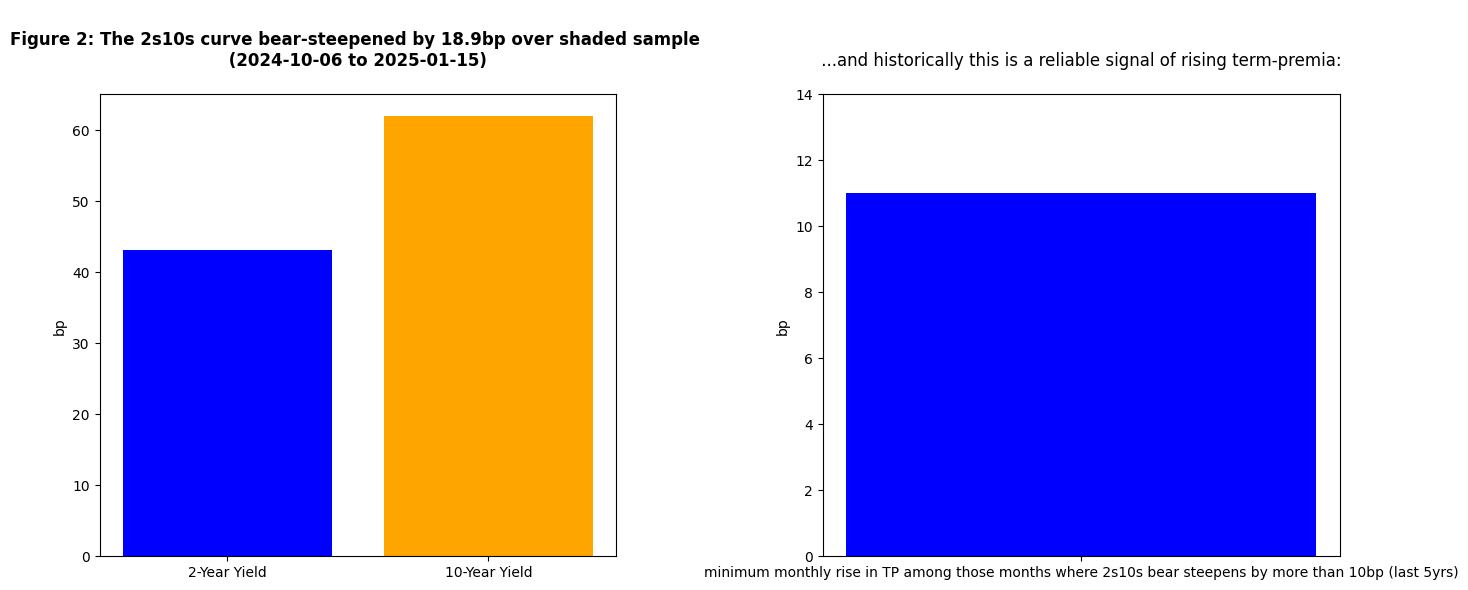

In [2960]:
# figure 2

# Assuming df_total is already defined and contains the necessary data

# Step 1: Filter the DataFrame to the specified date range
start_date = '2024-10-06'
end_date = '2025-01-15'
df_filtered = df_total[(df_total['Date'] >= start_date) & (df_total['Date'] <= end_date)]

# Step 2: Calculate the difference from start to finish for both 2-year and 10-year yields
start_2yr = df_filtered['2yr_yield'].iloc[0]*100  # First value in the filtered period
end_2yr = df_filtered['2yr_yield'].iloc[-1]*100  # Last value in the filtered period
start_10yr = df_filtered['10yr_yield'].iloc[0]*100  # First value in the filtered period
end_10yr = df_filtered['10yr_yield'].iloc[-1]*100  # Last value in the filtered period

# Calculate the difference from start to finish
difference_2yr = end_2yr - start_2yr
difference_10yr = end_10yr - start_10yr

total = difference_10yr - difference_2yr

# Step 3: Prepare for the first figure (2s10s curve bear-steepening)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4) 

# First subplot (Figure 2)
axes[0].bar(['2-Year Yield', '10-Year Yield'], [difference_2yr, difference_10yr], color=['blue', 'orange'])
axes[0].set_title(f'Figure 2: The 2s10s curve bear-steepened by {total:.1f}bp over shaded sample \n (2024-10-06 to 2025-01-15) \n', fontsize=12, fontweight='bold')
axes[0].set_ylabel('bp')

# Step 4: Plot the second figure (Minimum value for the bear condition)

# Create 'monthly_change_tp' and other relevant columns
df_total['monthly_change_tp'] = (df_total['10y_tp'] - df_total['10y_tp'].shift(30)) * 100
df_total['curve'] = df_total['10yr_yield'] - df_total['2yr_yield']
df_total['monthly_change_10yr'] = df_total['10yr_yield'] - df_total['10yr_yield'].shift(30)
df_total['monthly_change_2yr'] = df_total['2yr_yield'] - df_total['2yr_yield'].shift(30)
df_total['monthly_change_curve'] = df_total['curve'] - df_total['curve'].shift(30)
df_total['condition_bear'] = ((df_total['monthly_change_10yr'] > df_total['monthly_change_2yr']) & 
                              (df_total['monthly_change_2yr'] > 0) & 
                              (df_total['monthly_change_10yr'] > 0) & 
                              (df_total['monthly_change_curve'] > 0.10))

# Filter the DataFrame to get only the rows where condition_bear == 1
df_bear = df_total[df_total['condition_bear'] == 1]

# Calculate the minimum value of 'monthly_change_tp' for those rows
min_value = df_bear['monthly_change_tp'].min()

# Plot the second bar graph (Figure 2.1)
axes[1].bar('minimum monthly rise in TP among those months where 2s10s bear steepens by more than 10bp (last 5yrs)', min_value, color='blue', width=0.5)
axes[1].set_ylim(0, 14)  # Adjust y-limits
axes[1].set_title('\n\n ...and historically this is a reliable signal of rising term-premia: \n ')
axes[1].set_ylabel('bp')



#minimum monthly rise in TP for among those months where 2s10s bear steepens by more than 10bp (last 5 years) \n'

# Adjust layout for better spacing between subplots

# Save the figure as one image
plt.savefig(f'{figure_path}/figure_2.jpg', format='jpeg', bbox_inches='tight')

# Show the combined plot
plt.show()


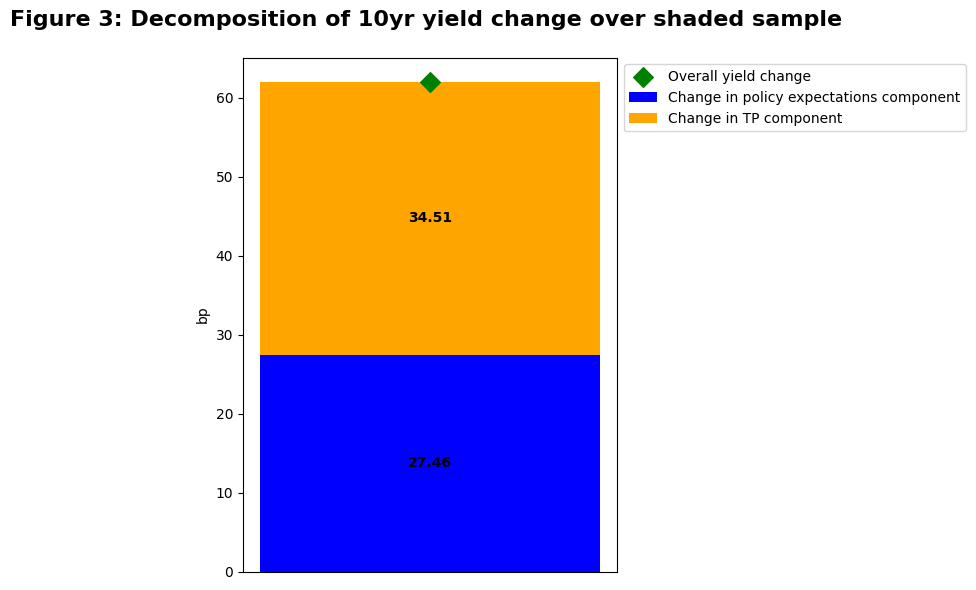

In [2976]:
# figure 3 

# Assuming the previous steps have been followed for filtering and calculating differences
start_date = '2024-10-06'
end_date = '2025-01-15'
df_filtered = df_total[(df_total['Date'] >= start_date) & (df_total['Date'] <= end_date)]

# Calculate the differences (same as before)
start_tp = df_filtered['10y_tp'].iloc[0]
end_tp = df_filtered['10y_tp'].iloc[-1]
start_policy = df_filtered['policy'].iloc[0]
end_policy = df_filtered['policy'].iloc[-1]

start_overall = df_filtered['10yr_yield'].iloc[0]
end_overall = df_filtered['10yr_yield'].iloc[-1]

difference_tp = (end_tp - start_tp)*100 
difference_policy = (end_policy - start_policy)*100 
# Calculate the overall change
overall_change = (end_overall - start_overall)*100 


# Labels for the bars and positions
# The total change when both TP and Policy are stacked

# Bar width and positions
bar_width = 0.35
x_pos = np.arange(1)  # The x positions for the bars

# Step 3: Create the stacked bar plot
plt.figure(figsize=(8, 6))

# Plot the policy pricing change (bottom part of the stack)
policy_bar = plt.bar(x_pos[0], difference_policy, color='blue', width=bar_width, label='Change in policy expectations component')

# Plot the TP change stacked on top of the policy pricing change
tp_bar = plt.bar(x_pos[0], difference_tp, color='orange', width=bar_width, bottom=difference_policy, label='Change in TP component')

# Add a green diamond marker at the top of the stacked bars
plt.scatter(x_pos[0], overall_change, color='green', s=100, marker='D', label='Overall yield change')

# Adding labels and title
plt.title(f'Figure 3: Decomposition of 10yr yield change over shaded sample \n', fontsize=16, fontweight='bold')
plt.ylabel('bp')

# Remove x-axis ticks and labels
plt.xticks([])  # This removes the ticks
plt.xlabel('')  # This removes the x-axis label

# Set the x-ticks to the correct position and add labels

# Add the height labels in the middle of each bar
# For the stacked bars (Policy pricing + TP change)
plt.text(x_pos[0], difference_policy / 2, f'{difference_policy:.2f}', ha='center', va='center', color='black', fontweight='bold')
plt.text(x_pos[0], difference_policy + (difference_tp / 2), f'{difference_tp:.2f}', ha='center', va='center', color='black', fontweight='bold')

# Add a legend outside the plot to the top-left corner (creating extra space)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout so the legend doesn't overlap with the bars
plt.tight_layout()


plt.savefig(f'{figure_path}/figure_3.jpg', format='jpeg', bbox_inches='tight')

# Show the plot
plt.show()


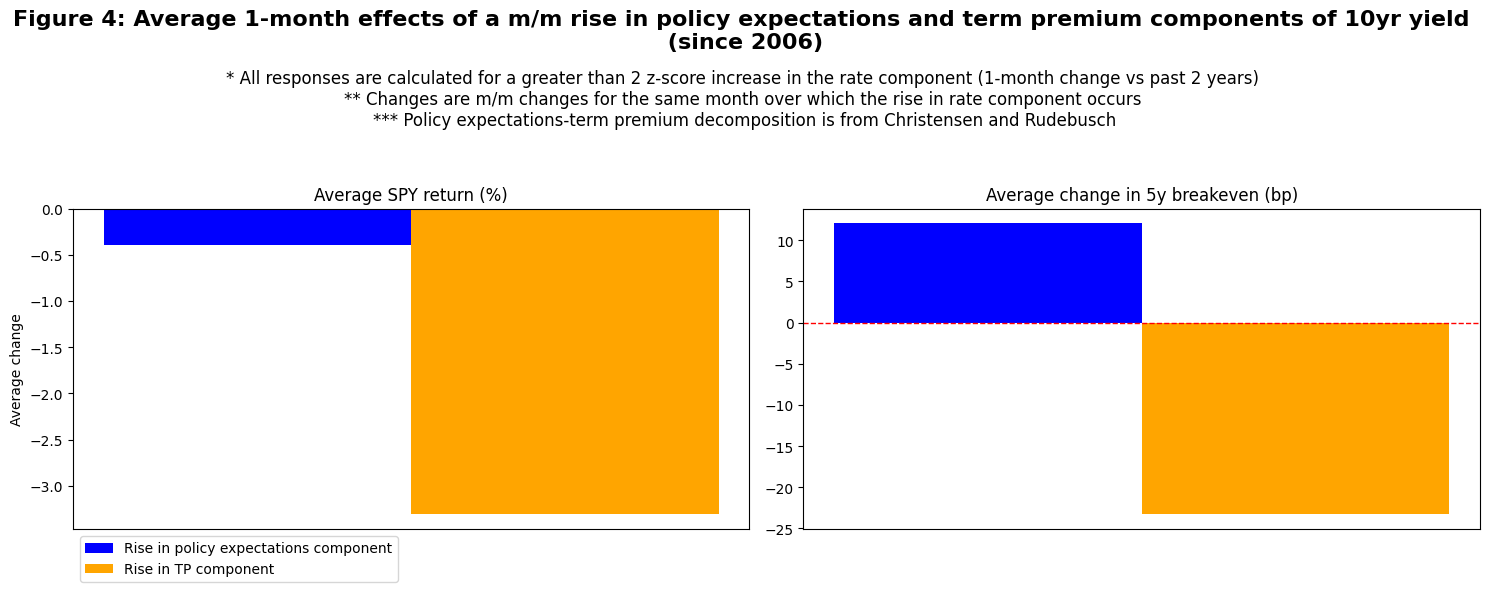

In [2998]:
# Figure 4


df_trial['policy_1month'] = df_trial['policy'].diff(30) 
df_trial['5yBE_1month'] = df_trial['5yBE'].diff(30) 
df_trial['spy_1month'] = (df_trial['spy'].diff(30) / df_trial['spy'].shift(30)) * 100
df_trial['tp_1month'] = df_trial['10y_tp'].diff(30)

df_trial['policy_monthly_change_std'] = df_trial['policy_1month'].rolling(window=365).std()
df_trial['policy_monthly_change_mean'] = df_trial['policy_1month'].rolling(window=365).mean()

df_trial['tp_monthly_change_std'] = df_trial['tp_1month'].rolling(window=365).std()
df_trial['tp_monthly_change_mean'] = df_trial['tp_1month'].rolling(window=365).mean()

df_trial['monthly_change_policy_z_score'] = (df_trial['policy_1month'] - df_trial['policy_monthly_change_mean']) / df_trial['policy_monthly_change_std']
df_trial['monthly_change_tp_z_score'] = (df_trial['tp_1month'] - df_trial['tp_monthly_change_mean']) / df_trial['tp_monthly_change_std']



# Initialize responses dictionary
responses = {'policy': [], 'tp': []}


# Loop through each shock type and compute the averages
for shock_type in ['policy', 'tp']:
    filtered_df = df_trial[df_trial[f'monthly_change_{shock_type}_z_score'] > 2]
    
    # Calculate averages for the variables of interest
    average_spy_change = filtered_df['spy_1month'].mean() 
    average_BE_change = filtered_df['5yBE_1month'].mean()
    if shock_type == 'policy':
        # Append the averages as a dictionary to the corresponding shock_type
        responses[shock_type].append({
            'Average SPY return (%)': average_spy_change, 
            'Average change in 5y breakeven (bp)': average_BE_change
        })

    else:
        # Append the averages as a dictionary to the corresponding shock_type
        responses[shock_type].append({
            'Average SPY return (%)': average_spy_change, 
            'Average change in 5y breakeven (bp)': average_BE_change
        })

# Now create a DataFrame from the responses dictionary
# Flatten the dictionary and automatically create columns for each key
df_responses = pd.DataFrame(responses['policy'] + responses['tp'])

# Add 'Shock Type' column with the values
df_responses['Shock Type'] = ['policy', 'tp']

# Re-arrange columns so that 'Shock Type' is the first column
categories = [col for col in df_responses.columns if col != 'Shock Type']
shock_types = df_responses['Shock Type'].values  # ['policy', 'tp']

# The values for each category (average values for policy and tp)
values_policy = df_responses.loc[df_responses['Shock Type'] == 'policy'][categories].values.flatten()
values_tp = df_responses.loc[df_responses['Shock Type'] == 'tp'][categories].values.flatten()

# Set up positions for the bars
x = np.arange(len(categories))  # The x positions of the categories
width = 0.35  # Width of each bar

# Create the plot with subplots in a single row
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row and 3 columns of subplots

# List of axes for easier iteration
axs = axes.ravel()

# Plot each variable on its own subplot

for i, category in enumerate(categories):

    # Get the data for the current category
    values_category_policy = values_policy[i]
    values_category_tp = values_tp[i]
    
    # Plot bars for 'policy' and 'tp' on the current subplot


    axs[i].bar(x[i] - width / 2, values_category_policy, width, label='Rise in policy expectations component', color='blue')
    axs[i].bar(x[i] + width / 2, values_category_tp, width, label='Rise in TP component', color='orange')

    # Set labels, title, and custom x-axis tick labels for the current subplot
    if i==0:
        axs[i].set_ylabel('Average change')
        axs[i].set_title(f'{category}')

    axs[i].set_title(f'{category}')

    if i==1:
        axs[i].axhline(0, color='red', linestyle='--', linewidth=1)  # Add a red dashed line at 0

    # Set the x-ticks to be in the middle of each pair of bars (so two bars for each category)
    axs[i].set_xticks([])  # Set the tick at the category position
    axs[i].set_xticklabels([])  # These are the tick labels for the shock types
    
    if i==0:
        axs[i].legend()
        axs[i].legend(loc='upper left', bbox_to_anchor=(0, 0))

fig.suptitle('Figure 4: Average 1-month effects of a m/m rise in policy expectations and term premium components of 10yr yield \n (since 2006) \n\n\n\n\n', fontsize=16, fontweight='bold')

fig.text(0.5, 0.88, 
                    '* All responses are calculated for a greater than 2 z-score increase in the rate component (1-month change vs past 2 years) \n'
                    '** Changes are m/m changes for the same month over which the rise in rate component occurs \n'
                    '*** Policy expectations-term premium decomposition is from Christensen and Rudebusch', ha='center', va='top', fontsize=12, color='black')



plt.tight_layout()


plt.savefig(f'{figure_path}/figure_4.jpg', format='jpeg',  bbox_inches='tight')

# Add some space between subplots

# Display the plot
plt.show()


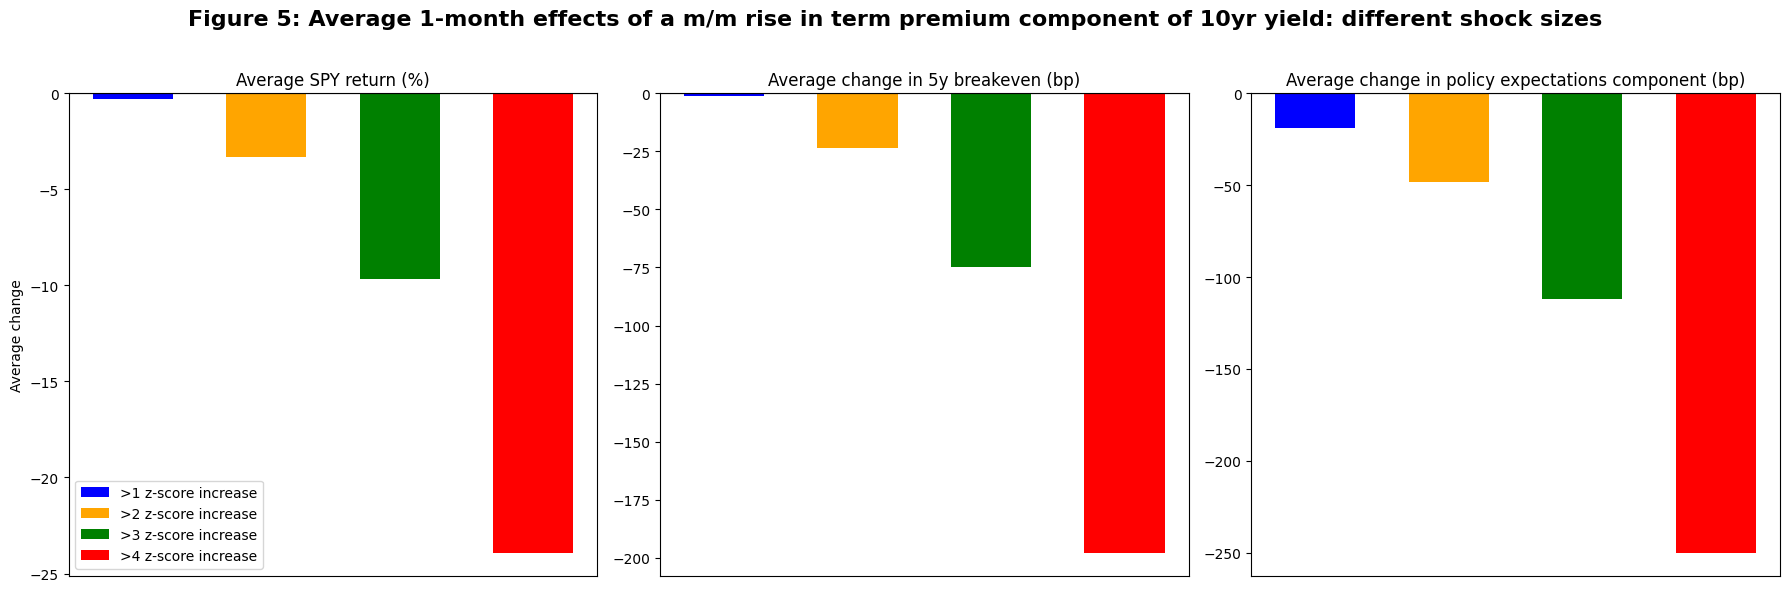

In [2994]:
# figure 5

# Initialize responses dictionary
responses = {
    '>1 z-score rise in tp': [],
    '>2 z-score rise in tp': [],
    '>3 z-score rise in tp': [],
    '>4 z-score rise in tp': []
}

# Loop through each shock size and compute the averages
for shock_size in [1, 2, 3, 4]:  # Added shock size 1
    # Filter the data based on the shock size (z-score > threshold)
    filtered_df = df_trial[df_trial['monthly_change_tp_z_score'] > shock_size]
    
    # Calculate averages for the variables of interest
    average_spy_change = filtered_df['spy_1month'].mean() 
    average_BE_change = filtered_df['5yBE_1month'].mean()
    average_policy_change = filtered_df['policy_1month'].mean()

    # Append the averages to the corresponding list in the responses dictionary
    responses[f'>{shock_size} z-score rise in tp'].append(average_spy_change)
    responses[f'>{shock_size} z-score rise in tp'].append(average_BE_change)
    responses[f'>{shock_size} z-score rise in tp'].append(average_policy_change)

# Convert the dictionary into a DataFrame
df_responses = pd.DataFrame({
    'SPY return (%)': [responses['>1 z-score rise in tp'][0], responses['>2 z-score rise in tp'][0], responses['>3 z-score rise in tp'][0], responses['>4 z-score rise in tp'][0]],
    'change in 5y breakeven (bp)': [responses['>1 z-score rise in tp'][1], responses['>2 z-score rise in tp'][1], responses['>3 z-score rise in tp'][1], responses['>4 z-score rise in tp'][1]],
    'change in policy expectations component (bp)': [responses['>1 z-score rise in tp'][2], responses['>2 z-score rise in tp'][2], responses['>3 z-score rise in tp'][2], responses['>4 z-score rise in tp'][2]]
}, index=['>1 z-score increase', '>2 z-score increase', '>3 z-score increase', '>4 z-score increase'])

# Plot the bar graphs for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row and 3 columns of subplots
metrics = ['SPY return (%)', 'change in 5y breakeven (bp)', 'change in policy expectations component (bp)']
colors = ['blue', 'orange', 'green', 'red']  # Added a red color for the shock size 1

# Iterate over each metric to plot the bar graphs
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Plot the bar graph for the current metric
    bars = ax.bar(df_responses.index, df_responses[metric], color=colors, width=0.6)
    
    # Set the title, x-label, and y-label for each subplot
    ax.set_title(f'Average {metric}')
    ax.set_xlabel('')  # Remove the x-axis label
    ax.set_ylabel(f'Average change' if i == 0 else '')  # Only set ylabel on the first subplot

    # Remove x-axis ticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])

    # Add a horizontal line at y=0 for reference
    ax.axhline(0, color='black',linewidth=0.8)

    # Custom legend with the appropriate labels
    if i == 0:
        ax.legend(bars, ['>1 z-score increase', '>2 z-score increase', '>3 z-score increase', '>4 z-score increase'], loc='lower left')

    
fig.suptitle('Figure 5: Average 1-month effects of a m/m rise in term premium component of 10yr yield: different shock sizes', fontsize=16, fontweight='bold')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the top margin to fit the main title
plt.savefig(f'{figure_path}/figure_5.jpg', format='jpeg', bbox_inches='tight')

# Show the plot
plt.show()
